In [2]:
import seaborn as sns
import networkx as nx
import pandas as pd
import freeman as fm

# Funções:

In [78]:
def load(inDegree):
    g = fm.load('./NetworkBuilder/network/655275.gml')
    removed = []
    for n, m in g.edges:
        if g.in_degree(n) <= inDegree:
            removed.append((n, m))
    for n, m in removed:
        g.remove_edge(n, m)

    # Remover todos os nós que ficaram isolados depois da
    # remoção das arestas, para melhorar a visualização.
    removed = []
    for n in g.nodes:
        if not g.degree(n):
            removed.append(n)
    for n in removed:
        g.remove_node(n)

    return g

In [79]:
def draw(g):
    # Deixar os nós menores e fazer os nomes deles
    # aparecer apenas quando o mouse passa por cima.
    g.set_all_nodes(size=10, labpos='hover')

    # Deixar as arestas semi-transparentes para
    # a visualização ficar um pouco mais leve.
    g.set_all_edges(color=(0, 0, 0, 0.25))

    # Usar um algoritmo especial para posicionar
    # os nós de acordo com grupos.
    g.move('kamada_kawai')

    g.draw()

In [80]:
def getCentralization(centrality, c_type):

    c_denominator = float(1)

    n_val = float(len(centrality))

    print(str(len(centrality)) + "," +  c_type + "\n")

    if (c_type=="degree"):
        c_denominator = (n_val-1)*(n_val-2)

    if (c_type=="close"):
        c_top = (n_val-1)*(n_val-2)
        c_bottom = (2*n_val)-3	
        c_denominator = float(c_top/c_bottom)

    if (c_type=="between"):
        c_denominator = (n_val*n_val*(n_val-2))

    if (c_type=="eigen"):

        '''
        M = nx.to_scipy_sparse_matrix(G, nodelist=G.nodes(),weight='weight',dtype=float)
        eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR') 
        largest = eigenvector.flatten().real
        norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
        centrality = dict(zip(G,map(float,largest)))
        '''

        c_denominator = sqrt(2)/2 * (n_val - 2)
        
        
        

    #start calculations	

    c_node_max = max(centrality.values())


    c_sorted = sorted(centrality.values(),reverse=True)
    


    print ("max node" + str(c_node_max) + "\n")

    c_numerator = 0

    for value in c_sorted:

        if c_type == "degree":
            #remove normalisation for each value
            c_numerator += (c_node_max*(n_val-1) - value*(n_val-1))
        else:
            c_numerator += (c_node_max - value)

    print ('numerator:' + str(c_numerator)  + "\n")	
    print ('denominator:' + str(c_denominator)  + "\n")	

    network_centrality = float(c_numerator/c_denominator)

    if c_type == "between":
        network_centrality = network_centrality * 2

    return network_centrality

# Início da análise:

In [81]:
g = fm.load('./NetworkBuilder/network.gml')

In [82]:
data = pd.DataFrame({
    'wallet': list(g.nodes),
    'indegree': [g.in_degree(n) for n in g.nodes],
    'outdegree': [g.out_degree(n) for n in g.nodes],
})

In [83]:
data

,wallet,indegree,outdegree
0,0,0,2
1,1,0,1
2,2,0,2
3,3,1,0
4,4,2,0
...,...,...,...
48903,48903,0,2
48904,48904,1,0
48905,48905,0,2
48906,48906,1,2


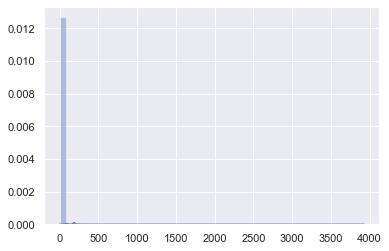

In [84]:
sns.distplot([g.in_degree(n) for n in g.nodes]);

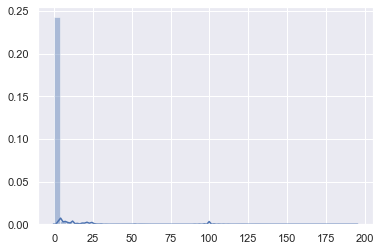

In [85]:
sns.distplot([g.out_degree(n) for n in g.nodes]);

Realizamos um filtro dos nós que possuem um in degree de 0, para conseguirmos visualizar a rede

In [86]:
g = load(0)

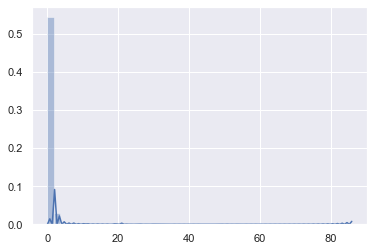

In [88]:
sns.distplot([g.in_degree(n) for n in g.nodes]);

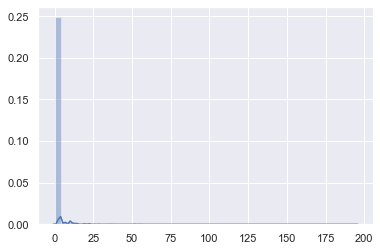

In [89]:
sns.distplot([g.out_degree(n) for n in g.nodes]);

In [90]:
BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g)

In [91]:
getCentralization(BETWEENNESS_CENTRALITY, "between")

8073,between

max node0.0005214499316583164

numerator:4.207286125403556

denominator:526013938359.0



1.599686175058015e-11

In [92]:
g = fm.load('./NetworkBuilder/network.gml')
BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g)
getCentralization(BETWEENNESS_CENTRALITY, "between")

KeyboardInterrupt: 

# Regressão

In [3]:
df = pd.read_excel("./NetworkBuilder/vol_df.xlsx")
df

,Unnamed: 0,Block,Volatilidade
0,0,655296,24.035537
1,1,655279,4.520072
2,2,655280,4.520072
3,3,655404,21.024753
4,4,655392,13.703780
...,...,...,...
123,123,655391,13.703780
124,124,655305,9.485255
125,125,655352,5.814146
126,126,655344,6.982547


In [ ]:
import os

centralidades = {}
networks = os.listdir('./NetworkBuilder/network/')
for n in networks:
    g = fm.load('./NetworkBuilder/network/' + n)
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g)
    centralidades[n[:-5]] = getCentralization(BETWEENNESS_CENTRALITY, "between")



In [98]:
import statsmodels.api as sm


# Primeiro parâmetro: Y
# Segundo parâmetro: X1, ..., Xn (não esqueça os colchetes duplos)
model = sm.OLS(volatilidade, centralidades)
result = model.fit()
result.summary()

/Users/luvi/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.319
Model:                            OLS   Adj. R-squared (uncentered):              0.243
Method:                 Least Squares   F-statistic:                              4.218
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                      0.0702
Time:                        23:08:45   Log-Likelihood:                          50.859
No. Observations:                  10   AIC:                                     -99.72
Df Residuals:                       9   BIC:                                     -99.41
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.026e+08   4.99e+07      2.054      0.070   -1.04e+07    2.16e+08
==============================================================================
Omnibus:                        6.144   Durbin-Watson:                   0.790
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.067
Skew:                          -1.356   Prob(JB):                        0.216
Kurtosis:                       3.095   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.97e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""